## References

- http://www.juliaopt.org/SumOfSquares.jl/latest/
- https://www.cs.colorado.edu/~xich8622/papers/thesis.pdf

## Support function of an interval

In this section, as a proof-of-principle, we compute the support function of an interval using SOS.

In [5]:
using SumOfSquares, DynamicPolynomials, MosekTools, TaylorModels, Plots

The support function of a set $X$ along direction $d$ is defined as the solution of the optimization problem:

$$
\rho(d, X) = \max \langle d, x \rangle \qquad s.t. x \in X.
$$
It represents how much the set $X$ is placed along direction $d$.

In [ ]:
function sf(d::Vector, X::Interval)
    model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))
    @variable(model, x[1])
    @constraint(model, inf(X) <= x[1])
    @constraint(model, x[1] <= sup(X))
    @objective(model, Max, d[1] * x[1])
    optimize!(model)
    
    return objective_value(model)
end

Let's consider an example:

In [ ]:
X = Interval(-2.0, 7.0)

In [ ]:
sf([1.0], X)

In [ ]:
sf([-1.0], X)

## Support function of a TaylorModel1

Now we consider the more general case of a univariate taylor model.

The set defined by a TM is $S := \{ x : x = p(x_0) + y \wedge x_0 \in \textrm{dom(TM)} \wedge y \in \textrm{rem(TM)}\}$.

We would like to compute $\max \langle d, x\rangle$, such that $x \in S$, where $S$ is the range of the taylor model.

To fix ideas, consider the following example.

In [6]:
p = Taylor1([1.0, 1.0, 1.0], 6)

 1.0 + 1.0 t + 1.0 t² + 𝒪(t⁷)

In [7]:
rem = Interval(-0.1, 0.1)
x0 = Interval(0, 0)
dom = Interval(-2.0, 2.0)
X = TaylorModel1(p, rem, x0, dom)

 1.0 + 1.0 t + 1.0 t² + [-0.100001, 0.100001]

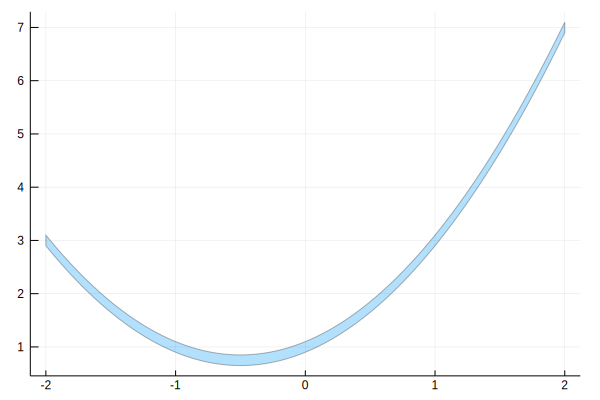

In [8]:
plot(X, lab="")

For the support function along direction $d = [1.0]$, we expect $7.1$, obtained when $x_0 = 2$ and $y = 0.1$.

For the support function along direction $d = [-1.0]$, we expect $0.65$, obtained when $x_0 = -0.5$ and $y = -0.1$.

#### Using Ipopt

In [ ]:
using Ipopt

In [ ]:
d = [1.0]; # direction

In [ ]:
model = Model(with_optimizer(Ipopt.Optimizer, print_level=0))

Xdom = domain(X)
Xrem = remainder(X)
@variable(model, inf(Xdom) <= x0 <= sup(Xdom))
@variable(model, inf(Xrem) <= y <= sup(Xrem))
@variable(model, x)
@NLconstraint(model, x == 1.0 + x0 + 1.0*x0^2 + y)
@objective(model, Max, d[1] * x)
model

In [ ]:
optimize!(model)
@show objective_value(model);

#### Using SumOfSquares

In [9]:
using SumOfSquares, DynamicPolynomials, MosekTools

In [16]:
model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=true))

@polyvar x0
Xdom, Xrem = domain(X), remainder(X)
@constraint(model, inf(Xdom) <= x0)
@constraint(model, x0 <= sup(Xdom))
@variable(model, inf(Xrem) <= y <= sup(Xrem))
@variable(model, x)
@constraint(model, x == 1.0 + x0 + 1.0*x0^2 + y)
@objective(model, Max, 1.0 * x)
model

A JuMP Model
Maximization problem with:
Variables: 2
Objective function type: GenericAffExpr{Float64,VariableRef}
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 1 constraint
`Array{GenericAffExpr{Float64,VariableRef},1}`-in-`SumOfSquares.SOSPolynomialSet{SemialgebraicSets.FullSpace,NonnegPolyInnerCone{MathOptInterface.PositiveSemidefiniteConeTriangle},MonomialBasis,Monomial{true},MonomialVector{true},Tuple{}}`: 2 constraints
`Array{GenericAffExpr{Float64,VariableRef},1}`-in-`PolyJuMP.ZeroPolynomialSet{SemialgebraicSets.FullSpace,MonomialBasis,Monomial{true},MonomialVector{true}}`: 1 constraint
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Mosek
Names registered in the model: x, y

In [17]:
optimize!(model)  
@show objective_value(model);

objective_value(model) = 0.0
